In [1]:
%matplotlib inline

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from maskfunctions import *

In [3]:
# Location and names of data files
data_dir = "/Users/jeremysmith/Documents/BTS_Airline_Data/"
file_pre = "On_Time_On_Time_Performance_2016"
path_airports = os.path.join(data_dir, "airports.dat")
path_emplanes = os.path.join(data_dir, "cy15-commercial-service-enplanements.csv")

In [4]:
# Delay Data
data_list = []
for month in range(12):
    file_month = "{:s}_{:02d}".format(file_pre, month + 1)
    path_month = os.path.join(data_dir, file_month, file_month + ".csv")
    data_list.append(pd.read_csv(path_month,
                                usecols=[2,3,4,5,8,10,14,23,31,33,36,39,42,44,47,52,54,56,57,58,59,60]))
data_delays = pd.concat(data_list, ignore_index=True)

In [5]:
data_delays.head()

,Month,DayofMonth,DayOfWeek,FlightDate,Carrier,FlightNum,Origin,Dest,DepDelay,DepDel15,...,ArrDelay,ArrDel15,Cancelled,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,6,3,2016-01-06,AA,43,DFW,DTW,-3.0,0.0,...,-6.0,0.0,0.0,132.0,986.0,NaN,NaN,NaN,NaN,NaN
1,1,7,4,2016-01-07,AA,43,DFW,DTW,-4.0,0.0,...,-12.0,0.0,0.0,126.0,986.0,NaN,NaN,NaN,NaN,NaN
2,1,8,5,2016-01-08,AA,43,DFW,DTW,-5.0,0.0,...,7.0,0.0,0.0,135.0,986.0,NaN,NaN,NaN,NaN,NaN
3,1,9,6,2016-01-09,AA,43,DFW,DTW,2.0,0.0,...,-5.0,0.0,0.0,129.0,986.0,NaN,NaN,NaN,NaN,NaN
4,1,10,7,2016-01-10,AA,43,DFW,DTW,100.0,1.0,...,113.0,1.0,0.0,137.0,986.0,0.0,0.0,47.0,0.0,66.0


In [29]:
# Airport Location Data
head_airports = ['Name', 'City', 'Country', 'IATA',
                 'Latitude', 'Longitude', 'Altitude',
                 'Timezone']
data_airports = pd.read_csv(path_airports,
                           usecols=[1,2,3,4,6,7,8,9],
                           names=head_airports)

In [30]:
# Airport USA Enplanements Data
data_emplanes = pd.read_csv(path_emplanes,
                           usecols=[2,3,6,7,8],
                           thousands=',')
data_emplanes.rename(columns={'Locid':'IATA', 'CY 15 Enplanements':'CY15enplane'}, inplace=True)

In [31]:
# Merge Airport Data
data_airports_merged = pd.merge(data_emplanes, data_airports, on='IATA', how='left', copy=False)

In [32]:
data_airports_merged_us = data_airports_merged[data_airports_merged.Country == "United States"]
data_airports_merged_us = data_airports_merged_us[data_airports_merged_us.CY15enplane > 100000]
data_airports_merged_us.head()

,ST,IATA,S/L,Hub,CY15enplane,Name,City,Country,Latitude,Longitude,Altitude,Timezone
0,GA,ATL,P,L,49340732,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,33.636700,-84.428101,1026.0,-5
1,CA,LAX,P,L,36351272,Los Angeles International Airport,Los Angeles,United States,33.942501,-118.407997,125.0,-8
2,IL,ORD,P,L,36305668,Chicago O'Hare International Airport,Chicago,United States,41.978600,-87.904800,672.0,-6
3,TX,DFW,P,L,31589839,Dallas Fort Worth International Airport,Dallas-Fort Worth,United States,32.896801,-97.038002,607.0,-6
4,NY,JFK,P,L,27782369,John F Kennedy International Airport,New York,United States,40.639801,-73.778900,13.0,-5


In [33]:
# Output Airport Data
data_airports_merged_us.to_csv("visualization/airports.csv")

In [28]:
# Filter by values
airports = data_airports_merged['IATA'].values[:20]
carrier = 'UA'                                  # 2 letter carrier code or ALL
month = 9                                        # month (1 - 12, 0 = all)
dotw = 0                                         # day of the week (1 - 7, 0 = all)
delay_taxi = True                               # True = average delay time, False = average taxi time

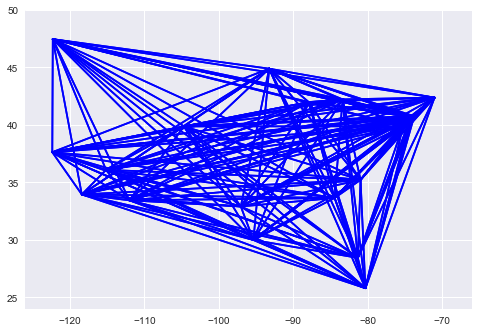

In [29]:
# Route permutations
for route in it.permutations(airports, 2):
    airport_info_orig = data_airports_merged[data_airports_merged.IATA == route[0]]
    airport_info_dest = data_airports_merged[data_airports_merged.IATA == route[1]]
    loc_orig = np.hstack((airport_info_orig.Longitude.values, airport_info_orig.Latitude.values))
    loc_dest = np.hstack((airport_info_dest.Longitude.values, airport_info_dest.Latitude.values))
    
    #mask, matches = create_mask(data_delays, route, carrier, month, dotw)
    #if delay_taxi:
    #    time = data_delays[mask].ArrDelay.median()
    #else:
    #    time = data_delays[mask].TaxiIn.median()

    plt.plot([loc_orig[0], loc_dest[0]],[loc_orig[1], loc_dest[1]],
             color='blue')
    
    #print "{} => {} {:6.1f}   {:d}".format(route[0], route[1], time, matches)
    #print "{} => {}".format(route[0], route[1], time, matches)

plt.axis([-126,-66,24,50])
plt.show()

ATL  -12.0
BOS   -9.0
CLT   -9.0
DEN  -11.0
DFW  -12.0
DTW  -13.0
EWR   -7.0
IAH   -9.0
LAS  -11.0
LAX   -5.0
LGA  -15.0
MCO   -9.0
MIA  -11.0
MSP   -8.0
ORD   -6.0
PHL   -9.0
PHX  -14.0
SEA  -10.0
SFO   -7.0


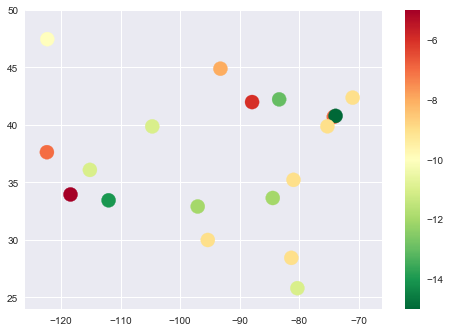

In [30]:
# Airport information
mask, matches = create_mask(data_delays, airports, carrier, month, dotw)
if delay_taxi:
    time = data_delays[mask].groupby('Origin').ArrDelay.median()
else:
    time = data_delays[mask].groupby('Origin').TaxiIn.median()

airports_with_data = data_delays[mask].Origin.unique()

airport_info = data_airports_merged[data_airports_merged.IATA.isin(airports_with_data)].sort_values('IATA')

for a in airport_info.IATA:
    print "{} {:6.1f}".format(a, time[a])

sc = plt.scatter(airport_info.Longitude.values, airport_info.Latitude.values,
                s=200,
                c=time.values,
                cmap=plt.cm.RdYlGn_r)
plt.axis([-126,-66,24,50])
plt.colorbar(sc)
plt.show()

In [31]:
mask, matches = create_mask(data_delays, 'ORD', carrier, month, dotw)
print "Number of data points   : {:d}".format(matches)
print "Average departure delay : {:6.2f} min".format(data_delays[mask].DepDelay.median())
print "Average taxi time out   : {:6.2f} min".format(data_delays[mask].TaxiOut.median())
print "Average arrival delay   : {:6.2f} min".format(data_delays[mask].ArrDelay.median())
print "Average taxi time in    : {:6.2f} min".format(data_delays[mask].TaxiIn.median())

Number of data points   : 6742
Average departure delay :   0.00 min
Average taxi time out   :  18.00 min
Average arrival delay   :  -6.00 min
Average taxi time in    :   6.00 min
